In [89]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os

In [90]:
main_directory = '../../MNIST/original-data/'
image_size = (32, 32)
batch_size = 32
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [91]:
train_files = os.path.join(main_directory, 'train')

classes = os.listdir(train_files)

train_images, labels_train = [], []

for class_ in classes:
    file_class = os.path.join(train_files, class_)
    images_class = [os.path.join(file_class, img) for img in os.listdir(file_class)]
    labels_class = [class_] * len(images_class)
    train_images.extend(images_class)
    labels_train.extend(labels_class)

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, labels_train, test_size = 0.1, stratify = labels_train,
    random_state = 42)

train_images = [s.replace('\\', '/') for s in train_images]
val_images = [s.replace('\\', '/') for s in val_images]

In [92]:
train_dataframe = pd.DataFrame({
    'images': train_images, 'labels': train_labels
})

val_dataframe = pd.DataFrame({
    'images': val_images, 'labels': val_labels
})

In [93]:
train_dataframe['labels'].value_counts()

labels
1    6068
7    5638
3    5518
2    5362
9    5354
0    5331
6    5326
8    5266
4    5258
5    4879
Name: count, dtype: int64

In [94]:
val_dataframe['labels'].value_counts()

labels
1    674
7    627
3    613
2    596
9    595
6    592
0    592
8    585
4    584
5    542
Name: count, dtype: int64

In [95]:
datagen = ImageDataGenerator(rescale = 1./255)

In [96]:
train_gen = datagen.flow_from_dataframe(
    dataframe = train_dataframe,
    x_col = 'images', y_col = 'labels',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    shuffle = False
)

val_gen = datagen.flow_from_dataframe(
    dataframe = val_dataframe,
    x_col = 'images', y_col = 'labels',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    shuffle = False
)

Found 54000 validated image filenames belonging to 10 classes.
Found 6000 validated image filenames belonging to 10 classes.


In [120]:
test_gen = datagen.flow_from_directory(
    directory = main_directory + 'test',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    shuffle = True, seed = 42
)

test_gen_get_labels = datagen.flow_from_directory(
    directory = main_directory + 'test',
    target_size = image_size,
    batch_size = 10000,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    shuffle = True, seed = 42
)

_, test_labels = test_gen_get_labels.next()
test_labels = np.argmax(test_labels, axis = 1)

Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


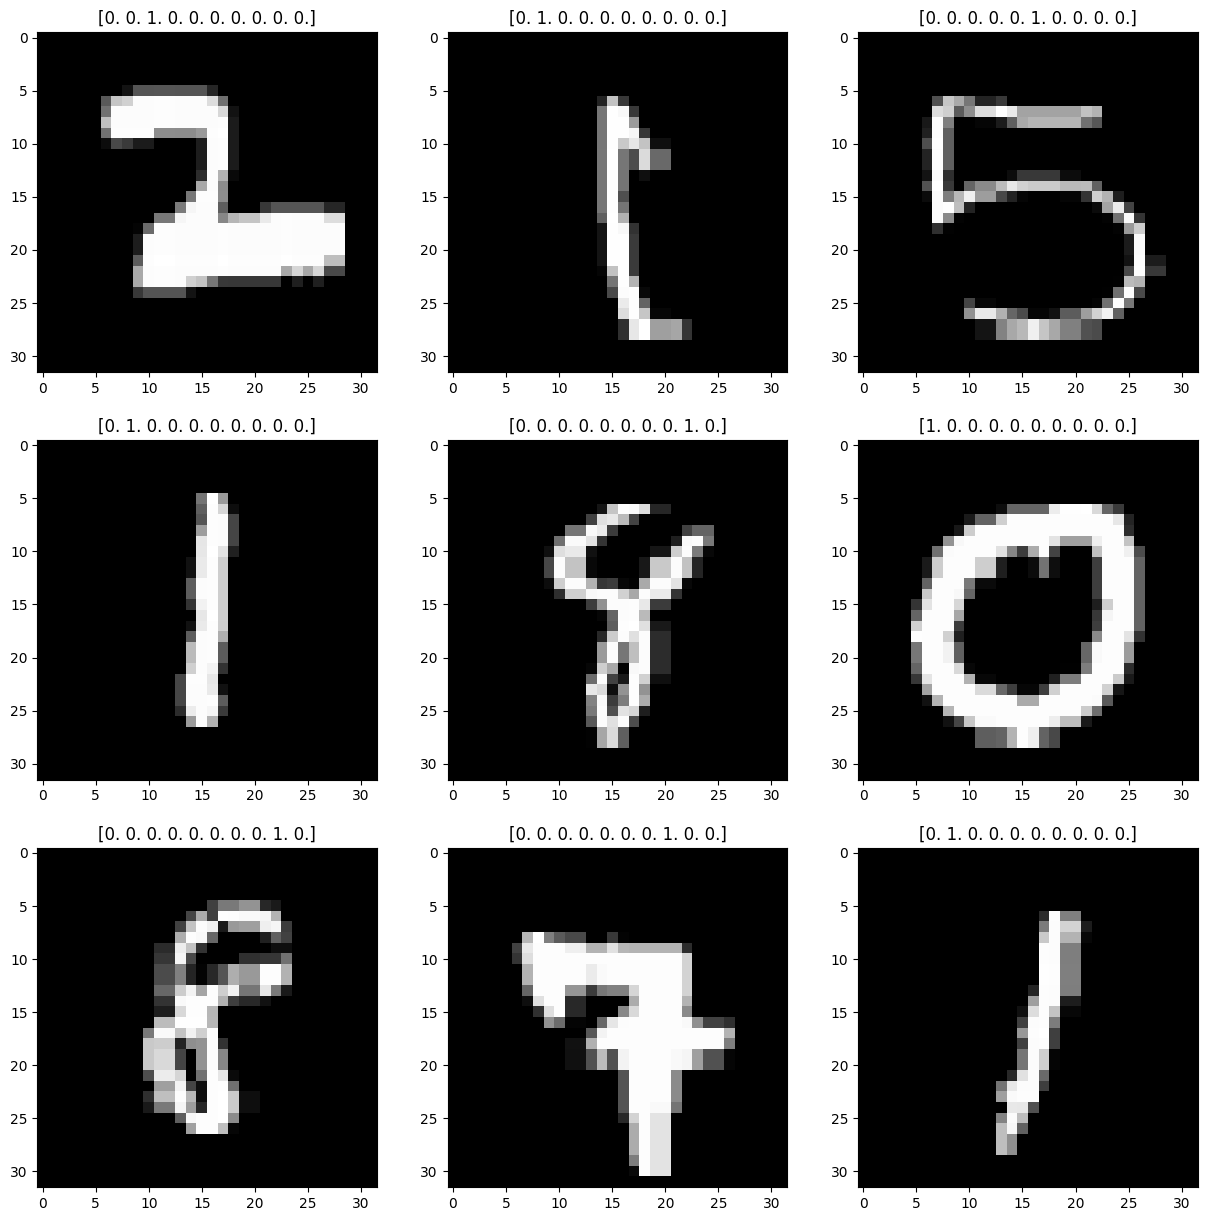

In [99]:
(x, y) = train_gen[0]
fig, axs = plt.subplots(3, 3, figsize = (15, 15))
count = 0
for i in range(0,3):
  for j in range(0,3):
    axs[i,j].set_title(str(y[count]))
    axs[i,j].imshow(x[count], cmap = 'gray')
    count +=1
     

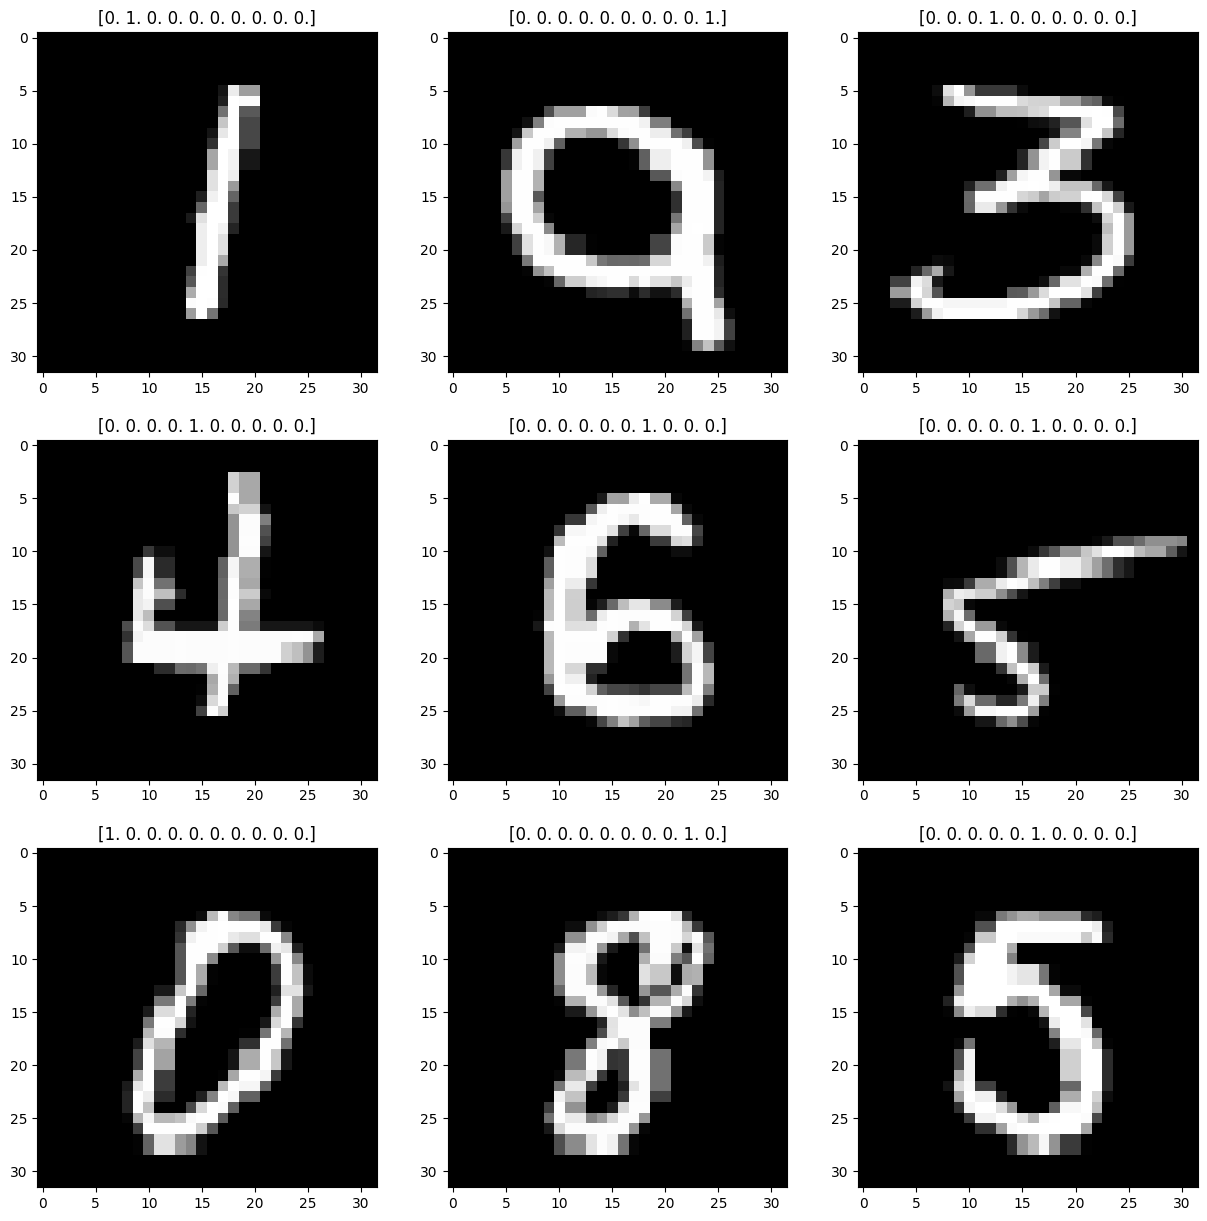

In [102]:
(x, y) = val_gen[0]
fig, axs = plt.subplots(3, 3, figsize = (15, 15))
count = 0
for i in range(0,3):
  for j in range(0,3):
    axs[i,j].set_title(str(y[count]))
    axs[i,j].imshow(x[count], cmap = 'gray')
    count +=1
     

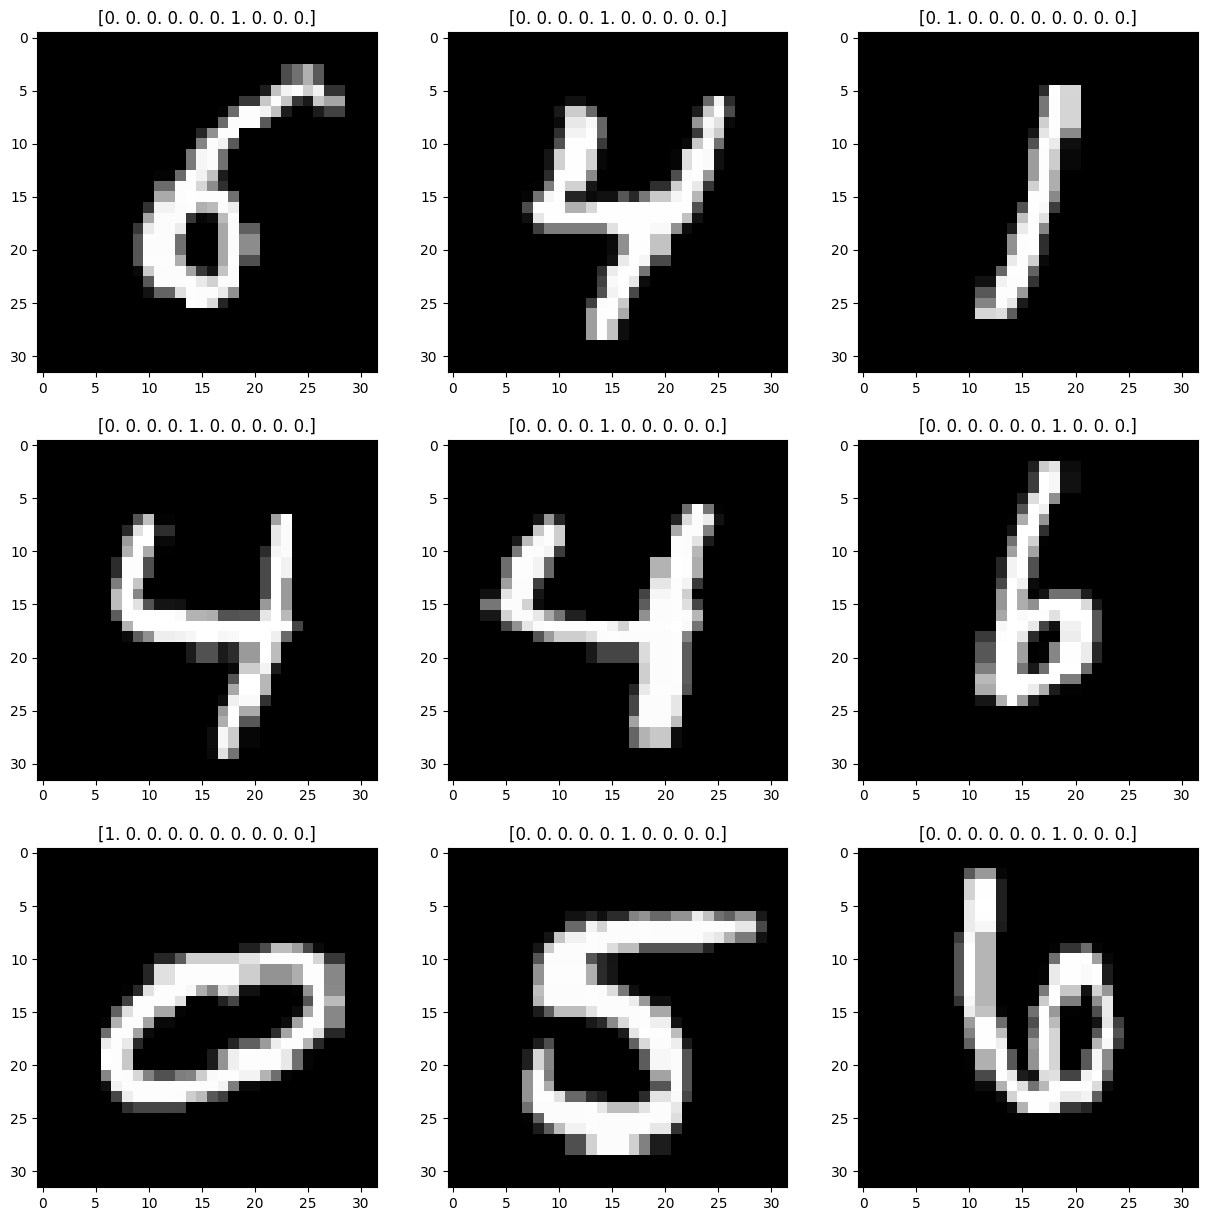

In [114]:
(x, y) = test_gen[0]
fig, axs = plt.subplots(3, 3, figsize = (15, 15))
count = 0
for i in range(0,3):
  for j in range(0,3):
    axs[i,j].set_title(str(y[count]))
    axs[i,j].imshow(x[count], cmap = 'gray')
    count +=1
     

In [127]:
base_model = MobileNetV2(include_top = False, weights = None, input_shape = (32, 32, 1))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation = 'softmax')(x)
model_mobilenet = tf.keras.Model(base_model.input, output)
model_mobilenet.compile(optimizer = 'adam', 
                        loss = 'categorical_crossentropy',
                        metrics = ['accuracy'])

In [ ]:
epochs = 3

for epoch in range(epochs):
    
    model_mobilenet.fit(train_gen,
                    steps_per_epoch = len(train_dataframe) / batch_size,
                    validation_data = val_gen,
                    epochs = 1, verbose = 1)

    y_treino_pred = model_mobilenet.predict(train_gen)
    y_treino_pred_classes = np.argmax(y_treino_pred, axis = 1)
    acuracia_treino = accuracy_score(train_gen.labels, y_treino_pred_classes)
    precisao_treino = precision_score(train_gen.labels, y_treino_pred_classes, 
                                      average = 'weighted')
    sensibilidade_treino = recall_score(train_gen.labels, y_treino_pred_classes, 
                                        average = 'weighted')
    f1_score_treino = f1_score(train_gen.labels, y_treino_pred_classes, 
                               average = 'weighted')

    y_validacao_pred = model_mobilenet.predict(val_gen)
    y_validacao_pred_classes = np.argmax(y_validacao_pred, axis = 1)
    acuracia_validacao = accuracy_score(val_gen.labels, y_validacao_pred_classes)
    precisao_validacao = precision_score(val_gen.labels, y_validacao_pred_classes, 
                                         average = 'weighted')
    sensibilidade_validacao = recall_score(val_gen.labels, y_validacao_pred_classes, 
                                           average = 'weighted')
    f1_score_validacao = f1_score(val_gen.labels, y_validacao_pred_classes, 
                                  average = 'weighted')

    print(f'Epoch {epoch + 1}:')
    print(f'Accuracy (train): {acuracia_treino:.4f}')
    print(f'Precision (train): {precisao_treino:.4f}')
    print(f'Recall (train): {sensibilidade_treino:.4f}')
    print(f'F1-score (train): {f1_score_treino:.4f}')
    print(f'Accuracy (validation): {acuracia_validacao:.4f}')
    print(f'Precision (validation): {precisao_validacao:.4f}')
    print(f'Recall (validation): {sensibilidade_validacao:.4f}')
    print(f'F1-score (validation): {f1_score_validacao:.4f}')
    print('---')